# Skin Cancer CNN Model

### Problem statement
- To build a CNN based model which can accurately detect melanoma. 
- Melanoma is a type of cancer that can be deadly if not detected early. 
- It accounts for 75% of skin cancer deaths. 
- A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### About the data

- This assignment uses a dataset of about 2357 images of skin cancer types. 
- The dataset contains 9 sub-directories in each train and test subdirectories. 
- The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Importing all the important libraries

In [93]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization

### Importing Skin Cancer Data

#### Setting path for Training and Test Images
Please note that the training has been done locally, and it is assumed that the notebook will be placed at the same level as the training dataset will be.

In [255]:
data_dir_train = pathlib.Path("Train/")
data_dir_test = pathlib.Path('Test/')

In [56]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Load the Data
- using image_dataset_from_directory keras utility

##### Define parameters


In [57]:
batch_size = 32
img_height = 180
img_width = 180

We will be using
- 80% images for Training
- 20% images for Validation

### Train Dataset

In [140]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            image_size=(img_height,img_width), seed=123, 
            directory=data_dir_train, batch_size=batch_size, 
            validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### Validataion Dataset

In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            image_size=(img_height,img_width), seed=123, 
            directory=data_dir_train, batch_size=batch_size, 
            validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### List of Image Classes

In [60]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names, num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 9


### Visualize the data
- Showing example images of all 9 classes

In [61]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

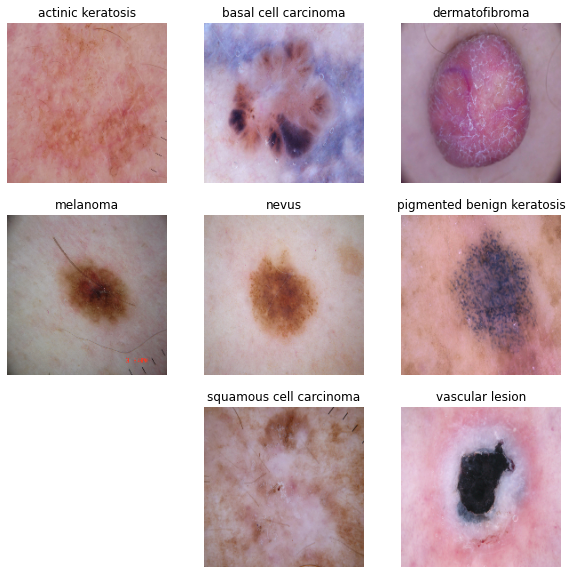

In [113]:
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [114]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


- The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. 
- This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). 
- The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [115]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

# Model Building

### Create the model
- Normalizing pixel values via ```layers.experimental.preprocessing.Rescaling``` 

##### Why
- The RGB channel values are in the `[0, 255]` range. 
- This is not ideal for a neural network. 
- Here, it is good to standardize values to be in the `[0, 1]`

## Model 1
- rescaling
- 3 x convolution layer
- 3 x max pooling layer
- flatten layer
- dense layer with relu activation

In [124]:
num_classes = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile the model
- cross entropy loss
- sgd optimizer

In [125]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [126]:
# View the summary of all layers
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 45, 45, 64)      

### Train the model

In [127]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 306ms/step - loss: 2.0517 - accuracy: 0.2109 - val_loss: 2.0183 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 16s 290ms/step - loss: 2.0115 - accuracy: 0.2232 - val_loss: 1.9889 - val_accuracy: 0.2528
Epoch 3/20
56/56 [==============================] - 16s 287ms/step - loss: 1.9899 - accuracy: 0.2455 - val_loss: 1.9603 - val_accuracy: 0.3087
Epoch 4/20
56/56 [==============================] - 16s 284ms/step - loss: 1.9455 - accuracy: 0.2991 - val_loss: 1.8994 - val_accuracy: 0.3244
Epoch 5/20
56/56 [==============================] - 16s 286ms/step - loss: 1.9442 - accuracy: 0.2757 - val_loss: 1.9666 - val_accuracy: 0.2841
Epoch 6/20
56/56 [==============================] - 16s 283ms/step - loss: 1.8916 - accuracy: 0.3231 - val_loss: 1.8073 - val_accuracy: 0.3512
Epoch 7/20
56/56 [==============================] - 16s 285ms/step - loss: 1.8748 - accuracy: 0.3131 - val_loss: 1.7825 - val_accuracy: 0.3535

### Visualizing training results

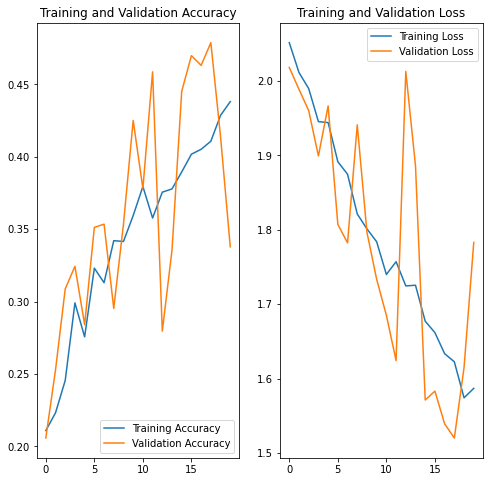

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

- In the initial few epochs, some improvement is seen in the accuracy for training and validation set. 
- After a while, the accuracy spikes are quite unusual to predict for validation set, while they are steadily increasing for training set. 
- In the last we can see there is a large gap in training and validation accuracy, which indicates that there maybe overfitting going on. However, the overall training score is close to 40% which means that the model is doing a poor job of learning the information.

---

# Model 2
- 4 convulational layers and 4 pooling layers
- batch normalization
- dropout

In [2]:
[
 [
     [10, 100, 1000], --> 0.1 --> 10 times
     [2, 3, 4] --> 0.02 -> 
 ], 
 [
     [20, 200, 2000],
     [1, 2, 3]
 ]
]

[[[10, 100, 1000], [2, 3, 4]], [[20, 200, 2000], [1, 2, 3]]]

In [94]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compile the model
- cross entropy loss
- sgd loss

In [95]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [96]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_18 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_17 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_19 (Activation)  (None, 178, 178, 32)      0         
                                                      

### Train the model

In [97]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 108s 2s/step - loss: 8.0252 - accuracy: 0.2450 - val_loss: 6.7979 - val_accuracy: 0.1320
Epoch 2/20
56/56 [==============================] - 107s 2s/step - loss: 1.8097 - accuracy: 0.3772 - val_loss: 11.0676 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 108s 2s/step - loss: 1.5662 - accuracy: 0.4448 - val_loss: 9.8450 - val_accuracy: 0.1521
Epoch 4/20
56/56 [==============================] - 109s 2s/step - loss: 1.4376 - accuracy: 0.5039 - val_loss: 6.6757 - val_accuracy: 0.2036
Epoch 5/20
56/56 [==============================] - 108s 2s/step - loss: 1.3179 - accuracy: 0.5491 - val_loss: 5.4244 - val_accuracy: 0.2886
Epoch 6/20
56/56 [==============================] - 108s 2s/step - loss: 1.2063 - accuracy: 0.5737 - val_loss: 4.5631 - val_accuracy: 0.2886
Epoch 7/20
56/56 [==============================] - 108s 2s/step - loss: 1.0998 - accuracy: 0.6077 - val_loss: 2.8711 - val_accuracy: 0.4094
Epoch 8/20
5

### Visualizing training results

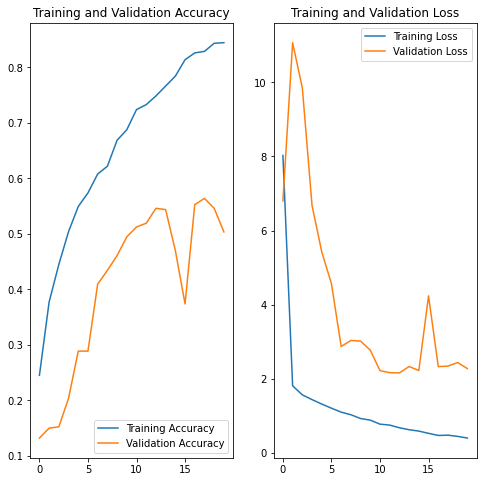

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
- The model is much better than the previous model, which means that adding more layers and neurons in each layer is helping in learning
- The training accuracry is touching close to 85%
- There is a strong evidence of overfitting as the number of epochs increases. The validation accuracy is dropping while training accuracy keeps on increasing.

#### To resolve the issue, we can try data augmentation

---

# Data Augmentation
- Since there overfitting, we can try to optimize it using Data Augmentation
- first we will try augmetation using the keras library itself.
- We will flip the image horizontally, rotate the image and apply zooming (randomly) as our augmetation strategy

In [129]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Visualizing the different augmented images

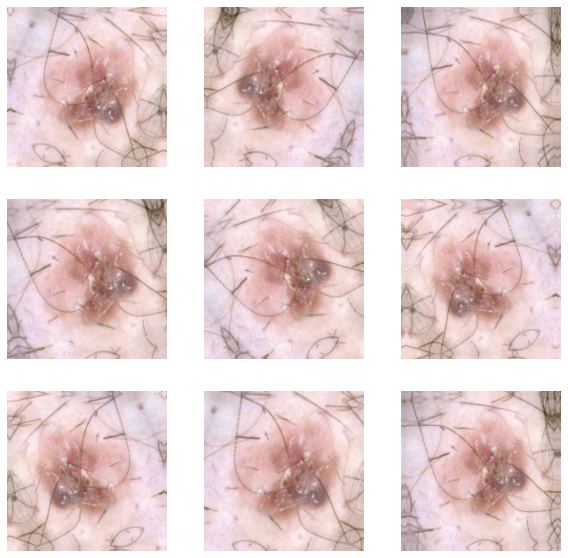

In [130]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

---

# Model 3
- config same as model 2 
- added data augmentation layer at the beginning

In [101]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [102]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_24 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      9248      
                                                     

In [104]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 111s 2s/step - loss: 7.7980 - accuracy: 0.2684 - val_loss: 5.9066 - val_accuracy: 0.1365
Epoch 2/20
56/56 [==============================] - 109s 2s/step - loss: 1.8848 - accuracy: 0.3605 - val_loss: 5.7212 - val_accuracy: 0.1521
Epoch 3/20
56/56 [==============================] - 110s 2s/step - loss: 1.7191 - accuracy: 0.3895 - val_loss: 5.4606 - val_accuracy: 0.1521
Epoch 4/20
56/56 [==============================] - 112s 2s/step - loss: 1.6795 - accuracy: 0.4102 - val_loss: 7.2816 - val_accuracy: 0.1611
Epoch 5/20
56/56 [==============================] - 112s 2s/step - loss: 1.5707 - accuracy: 0.4408 - val_loss: 4.9647 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 110s 2s/step - loss: 1.5107 - accuracy: 0.4554 - val_loss: 4.1165 - val_accuracy: 0.3132
Epoch 7/20
56/56 [==============================] - 110s 2s/step - loss: 1.4620 - accuracy: 0.4777 - val_loss: 3.0264 - val_accuracy: 0.3535
Epoch 8/20
56

### Visualizing the results

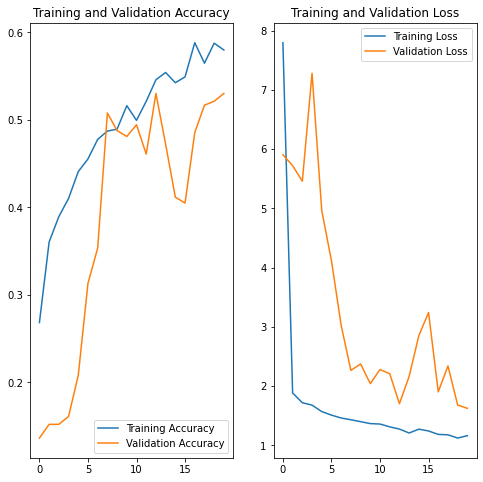

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
- Since the validation accuarcy is steadily increasing with training accuracy, we can say that the model is able to generalize well. In other words, we can say that the model is not overfitting.
- However, The training accuracy is quite low, close to 58% (validation is close to 53%), hence we can say that the model is underfitting.

---

# Class Imbalance Analysis

##### Why
- Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 
- Class imbalance can have a detrimental effect on the final model quality. 
- Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [148]:
image_class_count = {}
for image_class in os.listdir(data_dir_train):
    image_class_folder = os.path.join(data_dir_train, image_class)
    num_images_in_class = len(os.listdir(image_class_folder))
    print(f"{image_class}: {num_images_in_class}")
    image_class_count[image_class] = num_images_in_class 

actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


#### Minimum and Maximum Samples

In [151]:
dict(sorted(image_class_count.items(), key=lambda item: item[1]))

{'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'actinic keratosis': 114,
 'vascular lesion': 139,
 'squamous cell carcinoma': 181,
 'nevus': 357,
 'basal cell carcinoma': 376,
 'melanoma': 438,
 'pigmented benign keratosis': 462}

We can see that 
- `seborrheic keratosis` has the least number of samples (77)
- `pigmented benign keratosis` has the most number of samples (462)

## Fixing Class Imbalance
- We will use `Augmentor` library to add more samples across all classes so that none of the classes have very few samples.
- We will add 500 samples for each class to make sure none of the classes are sparse

In [155]:
# !pip install Augmentor

In [214]:
path_to_training_dataset=data_dir_train

import Augmentor
for class_name in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, class_name))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Executing Pipeline:   0%|                                            | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x16D005700D0>: 100%|█
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D29694220>:   4%| | 21/500 [00:00<00

Initialised with 376 image(s) found.
Output directory set to Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D29671FA0>: 100%|█| 500/500 [00:02<0
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D1FD06730>:   4%| | 21/500 [00:00<00

Initialised with 95 image(s) found.
Output directory set to Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x16D2ECE21C0>: 100%|█
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x16D2782DF40>:   0%|

Initialised with 438 image(s) found.
Output directory set to Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16D2ECB1880>: 100%|█| 500/500 [00:13<
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D2ED9FF10>:   0%| | 1/500 [00:00<00:

Initialised with 357 image(s) found.
Output directory set to Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D000AFD30>: 100%|█| 500/500 [00:12<0
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x16D2C838C10>:   4%| 

Initialised with 462 image(s) found.
Output directory set to Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D2C88AD60>: 100%|█| 500/500 [00:02<0
Executing Pipeline:   0%|                                            | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16D2C838760>: 100%|█| 500/500 [00:06<
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x16D2FC93FA0>:   2%| 

Initialised with 181 image(s) found.
Output directory set to Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x16D2ECB12E0>: 100%|█
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D2782D9A0>:   4%| | 19/500 [00:00<00

Initialised with 139 image(s) found.
Output directory set to Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16D00514220>: 100%|█| 500/500 [00:02<0


- Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. 
- Lets take a look at total count of augmented images.

In [208]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [209]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list

df_dict = dict(zip(path_list, lesion_list))

df = pd.DataFrame(list(df_dict.items()), columns=['Path', 'Label'])

In [210]:
df.head()

,Path,Label
0,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
1,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
2,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
3,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
4,Train\actinic keratosis\output\actinic keratos...,actinic keratosis


In [211]:
df['Label'].value_counts()

seborrheic keratosis          500
actinic keratosis             500
basal cell carcinoma          500
vascular lesion               500
squamous cell carcinoma       500
dermatofibroma                500
nevus                         500
pigmented benign keratosis    500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

---

## Model Building using Augmented Data

In [212]:
batch_size = 32
img_height = 180
img_width = 180

#### Moving all files from output folder to training folder for model building

In [216]:
import shutil

for folder in os.listdir(data_dir_train):
    print('Processing:', folder)
    folder_path = os.path.join(data_dir_train, folder)
    output = os.path.join(folder_path, 'output')
    for file in os.listdir(output):
        file_path = os.path.join(output, file)
        shutil.move(file_path, folder_path)
    os.rmdir(output)

Processing: actinic keratosis
Processing: basal cell carcinoma
Processing: dermatofibroma
Processing: melanoma
Processing: nevus
Processing: pigmented benign keratosis
Processing: seborrheic keratosis
Processing: squamous cell carcinoma
Processing: vascular lesion


In [220]:
image_class_count = {}
for image_class in os.listdir(data_dir_train):
    image_class_folder = os.path.join(data_dir_train, image_class)
    num_images_in_class = len(os.listdir(image_class_folder))
    #print(f"{image_class}: {num_images_in_class}")
    image_class_count[image_class] = num_images_in_class 

dict(sorted(image_class_count.items(), key=lambda x: x[1]))

{'seborrheic keratosis': 577,
 'dermatofibroma': 595,
 'actinic keratosis': 614,
 'vascular lesion': 639,
 'squamous cell carcinoma': 681,
 'nevus': 857,
 'basal cell carcinoma': 876,
 'melanoma': 938,
 'pigmented benign keratosis': 962}

#### We have reduced class imbalance by adding augmented samples

#### Create Training and Validation Dataset

In [225]:
data_dir_train="Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [228]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


---

## Model 4
- Network will be similar to Model 3
- removing keras augmentation
- using Augmentor based images

In [231]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [238]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [239]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_36 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_38 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_37 (Activation)  (None, 178, 178, 32)      0         
                                                     

In [240]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 312s 2s/step - loss: 2.2375 - accuracy: 0.1895 - val_loss: 11.3689 - val_accuracy: 0.1396
Epoch 2/30
169/169 [==============================] - 309s 2s/step - loss: 1.9664 - accuracy: 0.2600 - val_loss: 3.2213 - val_accuracy: 0.0973
Epoch 3/30
169/169 [==============================] - 314s 2s/step - loss: 1.8833 - accuracy: 0.2787 - val_loss: 7.5004 - val_accuracy: 0.1611
Epoch 4/30
169/169 [==============================] - 305s 2s/step - loss: 1.7847 - accuracy: 0.3303 - val_loss: 1.6619 - val_accuracy: 0.3927
Epoch 5/30
169/169 [==============================] - 307s 2s/step - loss: 1.7703 - accuracy: 0.3288 - val_loss: 2.6707 - val_accuracy: 0.2784
Epoch 6/30
169/169 [==============================] - 312s 2s/step - loss: 1.7085 - accuracy: 0.3494 - val_loss: 2.1419 - val_accuracy: 0.3526
Epoch 7/30
169/169 [==============================] - 312s 2s/step - loss: 1.6785 - accuracy: 0.3596 - val_loss: 1.6469 - val_accuracy: 0.395

### Visualizing the results

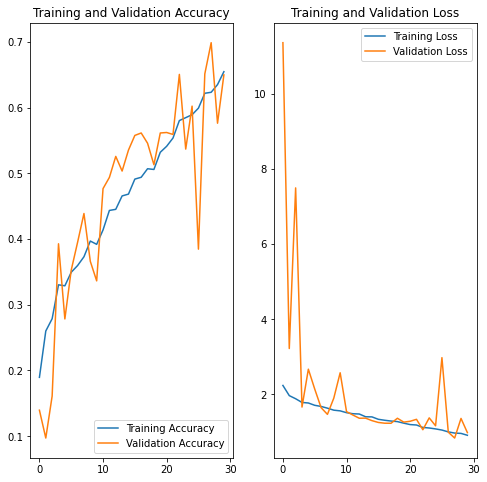

In [241]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
- Since the validation accuarcy is steadily increasing with training accuracy, we can say that the model is able to generalize well.
- The training and validation accuracy is around 65% which is certainly better than the previous model by large margin. The underfitting issue is being taken care of.

---

# Model 5
- adding keras augmentation layer back
- rest of the config is same as model 4

In [244]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [245]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [246]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_42 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_16 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_42 (Conv2D)          (None, 178, 178, 32)      9248      
                                                     

In [247]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 323s 2s/step - loss: 3.8013 - accuracy: 0.2595 - val_loss: 10.8017 - val_accuracy: 0.0913
Epoch 2/30
169/169 [==============================] - 319s 2s/step - loss: 1.6637 - accuracy: 0.3841 - val_loss: 6.4217 - val_accuracy: 0.2339
Epoch 3/30
169/169 [==============================] - 308s 2s/step - loss: 1.5409 - accuracy: 0.4227 - val_loss: 2.5146 - val_accuracy: 0.3972
Epoch 4/30
169/169 [==============================] - 298s 2s/step - loss: 1.4461 - accuracy: 0.4570 - val_loss: 2.2961 - val_accuracy: 0.4744
Epoch 5/30
169/169 [==============================] - 298s 2s/step - loss: 1.3786 - accuracy: 0.4844 - val_loss: 6.2276 - val_accuracy: 0.1886
Epoch 6/30
169/169 [==============================] - 292s 2s/step - loss: 1.3330 - accuracy: 0.4948 - val_loss: 3.9555 - val_accuracy: 0.3192
Epoch 7/30
169/169 [==============================] - 291s 2s/step - loss: 1.3093 - accuracy: 0.5134 - val_loss: 4.0531 - val_accuracy: 0.363

### Visualizing the results

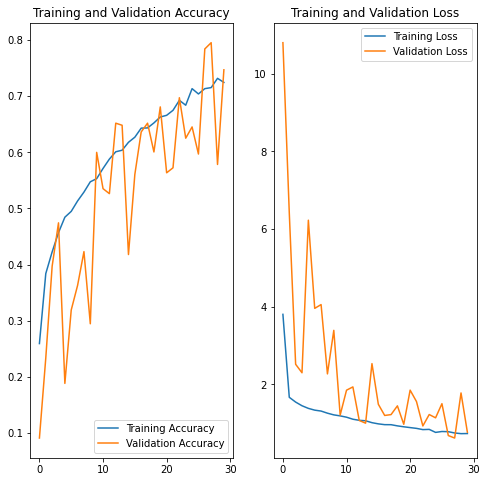

In [248]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
- Training accuracy for last epoch is 72%, and for validation it is 74%.
- The best validation accuracy was 79%, which means that we should store model at each epoch
- The validation accuracy is good, while both training and validation accuracy are close to each other, which means that the model is able to generalize well
- The issue related to overfitting & underfitting seem to be resolved by using the above model along with fixing the class imbalance
- Training the model for more epochs may lead to better scores

---

# Checking Model against Test Data Set

In [257]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            image_size=(img_height,img_width), seed=123, 
            directory=data_dir_test, batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [258]:
model.evaluate(test_ds)

4/4 [==============================] - 6s 292ms/step - loss: 3.7529 - accuracy: 0.3559


[3.752887010574341, 0.35593220591545105]

- Clearly, even though the model is doing well on training and validation sets, it is performing quite poorly on the test data set. 
- This indicates that the model may have memorized the training data instead of learning from it i.e. overfitting.
- As part of the next steps, I will look into resolving this problem

---